In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Causality-Experiments/Paper1/notebooks/multivariate"

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1i7sSt69-Q0ifBm21oC5B4EqD8-3EkGV8/Causality-Experiments/Paper1/notebooks/multivariate


In [2]:
!python -m pip install -r "../../requirements.txt"

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../causal_meta/models')
sys.path.insert(0, '../../causal_meta/modules')
sys.path.insert(0, '../../causal_meta/utils')

In [3]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook

from categorical import Marginal, Conditional, BiConditional
from data_utils_Ext import generate_data_categorical_extended
from models3 import *
from binary_ext import BinaryStructuralModel_extended

In [4]:
N = 10
model_1 = ModelA2BC(Marginal(N), Conditional(N), Conditional(N))
model_2 = ModelB2AC(Marginal(N), Conditional(N), Conditional(N))
model_3 = ModelC2AB(Marginal(N), Conditional(N), Conditional(N))
model_4 = ModelA2BC_B2C(Marginal(N), BiConditional(N), Conditional(N))
model_5 = ModelA2BC_C2B(Marginal(N), BiConditional(N), Conditional(N))
model_6 = ModelB2AC_A2C(Marginal(N), BiConditional(N), Conditional(N))
model_7 = ModelB2AC_C2A(Marginal(N), BiConditional(N), Conditional(N))
model_8 = ModelC2AB_A2B(Marginal(N), BiConditional(N), Conditional(N))
model_9 = ModelC2AB_B2A(Marginal(N), BiConditional(N), Conditional(N))

model = BinaryStructuralModel_extended(model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9)
real_model = ModelA2BC_B2C

In [10]:
num_episodes = 500
batch_size = 100 # 1
num_test = 10000
num_training = 1 # 100
num_transfers = 1 # 100

In [11]:
optimizer = torch.optim.SGD(model.modules_parameters(), lr=1.)

/usr/local/lib/python3.6/dist-packages/torch/optim/sgd.py:68: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(SGD, self).__init__(params, defaults)


In [26]:
torch.tensor([1.]).permute(0, 1)

RuntimeError: ignored

In [12]:
losses = np.zeros((9, num_training, num_transfers, num_episodes))

for k in tnrange(num_training):
    pi_A_1 = np.random.dirichlet(np.ones(N))
    pi_B_A = np.random.dirichlet(np.ones(N), size=N)
    pi_C_AB = np.random.dirichlet(np.ones(N), size=(N, N))
    for j in tnrange(num_transfers, leave=False):
        model.set_ground_truth(real_model, pi_A_1, pi_C_AB, pi_B_A)
        pi_A_2 = np.random.dirichlet(np.ones(N))
        x_val = torch.from_numpy(generate_data_categorical_extended(num_test, pi_A_2, pi_B_A, pi_C_AB))
        for i in range(num_episodes):
            x_transfer = torch.from_numpy(generate_data_categorical_extended(batch_size, pi_A_2, pi_B_A, pi_C_AB))
            model.zero_grad()
            loss_1 = -torch.mean(model.model_1(x_transfer))
            loss_2 = -torch.mean(model.model_2(x_transfer))
            loss_3 = -torch.mean(model.model_3(x_transfer))
            loss_4 = -torch.mean(model.model_4(x_transfer))
            loss_5 = -torch.mean(model.model_5(x_transfer))
            loss_6 = -torch.mean(model.model_6(x_transfer))
            loss_7 = -torch.mean(model.model_7(x_transfer))
            loss_8 = -torch.mean(model.model_8(x_transfer))
            loss_9 = -torch.mean(model.model_9(x_transfer))
            loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9
            
            with torch.no_grad():
                val_loss_1 = -torch.mean(model.model_1(x_val))
                val_loss_2 = -torch.mean(model.model_2(x_val))
                val_loss_3 = -torch.mean(model.model_3(x_val))
                val_loss_4 = -torch.mean(model.model_4(x_val))
                val_loss_5 = -torch.mean(model.model_5(x_val))
                val_loss_6 = -torch.mean(model.model_6(x_val))
                val_loss_7 = -torch.mean(model.model_7(x_val))
                val_loss_8 = -torch.mean(model.model_8(x_val))
                val_loss_9 = -torch.mean(model.model_9(x_val))

            losses[:, k, j, i] = [val_loss_1.item(), val_loss_2.item(), val_loss_3.item(), val_loss_4.item(), val_loss_5.item(), val_loss_6.item(), val_loss_7.item(), val_loss_8.item(), val_loss_9.item()]

            loss.backward()
            optimizer.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


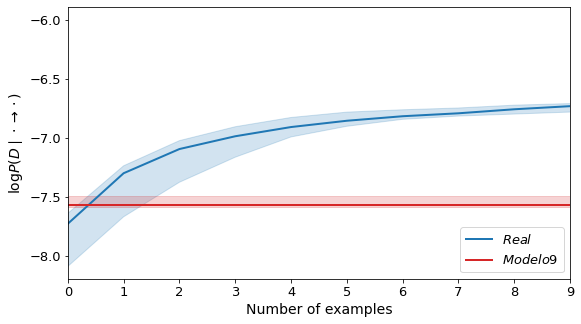

In [22]:
flat_losses = -losses.reshape((9, -1, num_episodes))
losses_25, losses_50, losses_75 = np.percentile(flat_losses, (25, 50, 75), axis=1)

plt.figure(figsize=(9, 5))

ind1 = 3
ind2 = 8

ax = plt.subplot(1, 1, 1)
ax.plot(losses_50[ind1], color='C0', label=r'$Real$', lw=2)
ax.fill_between(np.arange(num_episodes), losses_25[ind1], losses_75[ind1], color='C0', alpha=0.2)
ax.plot(losses_50[ind2], color='C3', label=f'$Modelo {ind2 + 1}$', lw=2)
ax.fill_between(np.arange(num_episodes), losses_25[ind2], losses_75[ind2], color='C3', alpha=0.2)
ax.set_xlim([0, flat_losses.shape[1] - 1])
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc=4, prop={'size': 13})
ax.set_xlabel('Number of examples', fontsize=14)
ax.set_ylabel(r'$\log P(D\mid \cdot \rightarrow \cdot)$', fontsize=14)

plt.show()